In [17]:
from typing import List, Dict
from tqdm import tqdm

# Analyse sur le hors domaine Priapées

## Objectifs

Évaluer et visualiser les résultats sur la vulgate

## Chargement du corpus GOLD

In [18]:
import lxml.etree as ET

GOLD: List[List[Dict[str, str]]] = [[]]
    
MILESTONES: List[int] = []
    
PRIA_START, PRIA_END = 2, 75
NS = {"t":"http://www.tei-c.org/ns/1.0"}

with open("../../../priapea-lemmat/priapea.xml") as f:
    xml = ET.parse(f)
    for ab_num, ab in enumerate(xml.xpath(
        "//t:ab", 
        namespaces=NS)):
        
        if ab_num < PRIA_START or ab_num > PRIA_END:
            continue
        
        for tok in ab.xpath("./t:w", namespaces=NS):
            token = tok.text
            try:
                lemma, pos, msd = (
                    tok.attrib["lemma"],
                    tok.attrib["pos"], 
                    tok.attrib["msd"]
                )
            except KeyError:
                print(ET.tostring(tok))
                raise
            if pos == "PUNC":
                if token in ".!?":
                    GOLD.append([])
                continue
            GOLD[-1].append({
                "form": token,
                "lemma": lemma,
                "pos": pos,
                "morph": msd
            })
            
        MILESTONES.append(sum(len([x for x in g if not x["form"].startswith("-")]) for g in GOLD if len(g)))
    
GOLD = [g for g in GOLD if len(g)]

In [19]:
#Debug:
print(MILESTONES)
print(len(MILESTONES))

[68, 87, 113, 144, 158, 182, 279, 319, 343, 417, 427, 482, 519, 565, 581, 595, 624, 661, 685, 699, 726, 750, 786, 840, 876, 902, 929, 958, 983, 1048, 1087, 1112, 1136, 1194, 1264, 1290, 1329, 1354, 1372, 1397, 1426, 1446, 1482, 1526, 1555, 1584, 1606, 1640, 1789, 1848, 1886, 1899, 1937, 1968, 2010, 2029, 2039, 2051, 2119, 2129, 2224, 2238, 2264, 2284, 2312, 2554, 2577, 2639, 2651, 2674, 2701, 2713, 2794, 2883]
74


## Reparse morphology for evaluation

In [20]:
TEMP = []
TASKS = "lemma,Deg,Numb,Person,Mood_Tense_Voice,Case,Gend,pos".split(",")
for sentence in tqdm(GOLD):
    temp_sentence = []
    for token in sentence:
        new_token = {task: "_" for task in TASKS}
        new_token.update({
            "form": token["form"].replace("v", "u").replace("j", "i").replace("J", "I").replace("V", "U"),#.lower(),
            "lemma": token["lemma"],#.lower(),
            # No POS distinction
            "pos": token["pos"].replace("com", "").replace("pro", "")
        })
        # No disambiguation at the lemmatizer lever
        if new_token["lemma"][-1].isnumeric():
            new_token["lemma"] = new_token["lemma"][:-1]
            
        # Treat morph as separate tasks
        for morph in token["morph"].split("|"):
            task, value = morph.split("=")
            new_token[task] = value
        new_token["Mood_Tense_Voice"] = "|".join([
            new_token.get(task, "_")
            for task in ("Mood", "Tense", "Voice")
        ]).replace("_|_|_", "_")
        
        if new_token["form"].startswith("-"):
            temp_sentence[-1]["form"] += new_token["form"][1:]
            temp_sentence[-1]["lemma"] += "界" + new_token["lemma"]
            continue
        temp_sentence.append(new_token)
        
    TEMP.append(temp_sentence)
GOLD = TEMP

100%|██████████| 168/168 [00:00<00:00, 13308.71it/s]


## Obtention des données (formes uniquement)

In [21]:
TOKENS = [
    [x["form"] for x in sentence]
    for sentence in GOLD
]
nb = 0
for sent in TOKENS:
    print(sent)
    nb += len(sent)
    print(len(sent), nb)

['Obscure', 'poteram', 'tibi', 'dicere', 'da', 'mihi', 'quod', 'tu', 'des', 'licet', 'assidue', 'nil', 'tamen', 'inde', 'perit']
15 15
['da', 'mihi', 'quod', 'cupies', 'frustra', 'dare', 'forsitan', 'olim', 'cum', 'tenet', 'obsessas', 'inuida', 'barba', 'genas', 'quodque', 'Ioui', 'dederat', 'qui', 'raptus', 'ab', 'alite', 'sacra', 'miscet', 'amatori', 'pocula', 'grata', 'suo', 'quod', 'uirgo', 'prima', 'cupido', 'dat', 'nocte', 'marito', 'dum', 'timet', 'alterius', 'uulnus', 'inepta', 'loci']
40 55
['simplicius', 'multo', 'est', 'da', 'pedicare', 'Latine', 'dicere', 'quid', 'faciam']
9 64
['crassa', 'Minerua', 'mea', 'est']
4 68
['Obscenas', 'rigido', 'deo', 'tabellas', 'ducens', 'ex', 'Elephantidos', 'libellis', 'dat', 'donum', 'Lalage', 'rogatque', 'temptes', 'si', 'pictas', 'opus', 'edat', 'ad', 'figuras']
19 87
['Quam', 'puero', 'legem', 'fertur', 'dixisse', 'Priapus', 'uersibus', 'haec', 'infra', 'scripta', 'duobus', 'erit', 'quod', 'meus', 'hortus', 'habet', 'sumas', 'impune', '

## Test

In [22]:
from pie.tagger import Tagger
from pie.utils import chunks
DEVICE = "cpu"
BATCH_SIZE = 128


OUTPUT = []
MODEL_PATH = "../../../latin-lasla-models/model.tar"

tagger = Tagger(device="cpu", batch_size=100, lower=False, tokenize=False)
tagger.add_model(MODEL_PATH, *TASKS)


for chunk in tqdm(chunks([(sent, len(sent)) for sent in TOKENS], tagger.batch_size)):
    tagged, tasks = tagger.tag(*zip(*chunk))#, use_beam=True)
    OUTPUT.extend([
        [
            (token, dict(zip(tasks, result)))
            for token, result in sentence
        ]
        for sentence in tagged
    ])

2it [00:04,  2.09s/it]


## Evaluation

In [23]:
from collections import defaultdict, Counter
RESULTS = []
RAW_SCORES = {
    task: ([], []) # Pred, Truth
    for task in TASKS
}
RAW_SCORES_NOT_EMPTY = {
    task: ([], []) # Pred, Truth
    for task in TASKS
}
ERRORS = {
    task: defaultdict(lambda: defaultdict(Counter))#{truth: {pred: {token: int}} # (token, pred, truth)
    for task in tasks
}
for p_sent, t_sent in zip(OUTPUT, GOLD):
    score_sentence = []
    for (_, p_tags), (t_tags) in zip(p_sent, t_sent):
        token = t_tags["form"]
        p_tags["lemma"] = p_tags["lemma"]#.lower()
        score_sentence.append((
            p_tags,
            t_tags,
            {task: p_tags[task] == t_tags[task] for task in TASKS}
        ))
        for task in tasks:
            RAW_SCORES[task][0].append(p_tags[task])
            RAW_SCORES[task][1].append(t_tags[task])
            if t_tags[task] != "_":
                RAW_SCORES_NOT_EMPTY[task][0].append(p_tags[task])
                RAW_SCORES_NOT_EMPTY[task][1].append(t_tags[task])
            if t_tags[task] != p_tags[task]:
                ERRORS[task][t_tags[task]][p_tags[task]][token] += 1
    RESULTS.append(score_sentence)

In [24]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tabulate import tabulate

data = [["Task", "Accuracy", "Accuracy on V != _"]]


for task, (pred, truth) in RAW_SCORES.items():
    (pred_limited, truth_limited) = RAW_SCORES_NOT_EMPTY[task]
    data.append([
        task,
        "{0:.3f}".format(accuracy_score(truth, pred)),
        "{0:.3f}".format(accuracy_score(pred_limited, truth_limited))
    ])
print(tabulate(data))

----------------  --------  ------------------
Task              Accuracy  Accuracy on V != _
lemma             0.940     0.940
Deg               0.966     0.900
Numb              0.944     0.941
Person            0.990     0.961
Mood_Tense_Voice  0.961     0.871
Case              0.892     0.840
Gend              0.916     0.780
pos               0.947     0.947
----------------  --------  ------------------


```
----------------  --------  ------------------
Task              Accuracy  Accuracy on V != _
lemma             0.92      0.92
Deg               0.96      0.90
Numb              0.94      0.94
Person            0.99      0.97
Mood_Tense_Voice  0.96      0.87
Case              0.88      0.81
Gend              0.92      0.81
pos               0.93      0.93
----------------  --------  ------------------
```

In [25]:
ERRORS["lemma"]

with open("1.4.X-Priapees-Lemma-Confusion.tsv", "w") as f:
    f.write("lemma\tprediction\ttoken\tnumber\n")
    for lemma in ERRORS["lemma"]:
        for pred in ERRORS["lemma"][lemma]:
            for token, count in ERRORS["lemma"][lemma][pred].items():
                f.write(f"{lemma}\t{pred}\t{token}\t{count}\n")

## Visualisation sur le corpus

In [26]:
from math import ceil
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

# Compute the accuracy on splits
        
SPLITS_TASK = {
    task: []
    for task in RAW_SCORES
}
SPLITS_TASK["size"] = []
DIVIDE_BY = round(sum([len(x) for x in GOLD]) / 20) # 5%

lengths = []
support_done = False
for task, (pred, truth) in RAW_SCORES.items():
    ms_start = 0
    for milestone in MILESTONES:
        SPLITS_TASK[task].append(accuracy_score(truth[ms_start:milestone], pred[ms_start:milestone]))
        length = milestone - ms_start + 1
        if not support_done:
            SPLITS_TASK["size"].append(length)
        ms_start = milestone
    support_done = True
        

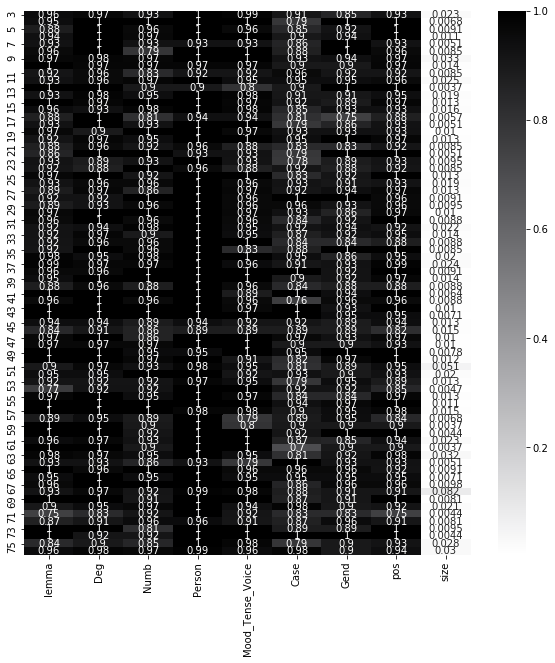

In [27]:
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

DF_PRIAPEES = DataFrame(SPLITS_TASK, index=list(range(PRIA_START+1, PRIA_END+2)))
DF_PRIAPEES["size"] = DF_PRIAPEES["size"] / sum(DF_PRIAPEES["size"])

plt.figure(figsize=(10,10))
cmap = sns.cubehelix_palette(250, hue=0.05, rot=0, light=1, dark=0, as_cmap=True)
ax = sns.heatmap(DF_PRIAPEES, annot=True, cmap=cmap)

## Analyse des Priapées en dessous de X %

In [28]:
from IPython.core.display import display, HTML

THRESHOLD = 0.99

TO_CHECK = [
    pria_id - PRIA_START - 1
    for pria_id in (DF_PRIAPEES["lemma"].loc[DF_PRIAPEES["lemma"] < THRESHOLD]).index
]
TO_CHECK_ID = list((DF_PRIAPEES["lemma"].loc[DF_PRIAPEES["lemma"] < THRESHOLD]).index)
    
pred, truth = RAW_SCORES["lemma"]
flatten_tokens = [tok for sent in TOKENS for tok in sent]
ms_start = 0

for pria_id, (ms_start, ms_end) in enumerate(zip([0] + MILESTONES, MILESTONES)):
    #if ms_end is not None:
    #    ms_end += 1
    if pria_id not in TO_CHECK:
        continue
    nice_id = TO_CHECK_ID.pop(0)
    text = []
    nb_tokens = ms_end - ms_start
    size = 1 / nb_tokens
    nb_errors = 0
    for tok, t, p in zip(flatten_tokens[ms_start:ms_end], truth[ms_start:ms_end], pred[ms_start:ms_end]):
        if t == p:
            text.append(tok)
        else:
            text.append(f"<span style='color: red;'>{tok}[<span style='color:green;'>{t}</span>,{p}]</span>")
            nb_errors += 1
            
    text = "<p>"+" ".join(text).replace(" -", "-") + "</p>"
    text = f"""<h2>Priapée {nice_id}</h2>
    <p>
        <small>
        <b>Accuracy:</b> {accuracy_score(truth[ms_start:ms_end], pred[ms_start:ms_end]):.3f} <br />
        <b>Tokens:</b> {ms_end - ms_start}<br />
        <b>Errors: </b> {nb_errors}<br />
        <b>1 error =</b> -{size*100:.1f} % drop in accuracy <br />
        <span style='color:green;'>Ground Truth</span> - <span style='color:red;'>Prediction</span>
        </small>
    </p>
    <p>{text}</p>
    """
    display(HTML(text))
    